In [1]:
import pandas as pd
import numpy as np
import numpy as np
import pandas as pd
from score_model import *
from gameover_model import *
import cv2
import pickle

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
import matplotlib.pyplot as plt

In [4]:
import seaborn as sns
import gc

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
import tensorflow as tf
from tqdm import tqdm

In [7]:
score_model = generate_scoring_model()
time_model = generate_time_model()
position_score_model = generate_position_model()

In [8]:
import pickle

def save_to_file(objeto, nome_arquivo):
    with open(nome_arquivo, 'wb') as output:
        pickle.dump(objeto, output, pickle.HIGHEST_PROTOCOL)

def load_file(nome_arquivo):
    with open(nome_arquivo, 'rb') as input:
        objeto = pickle.load(input)
    return objeto

In [9]:
def process_img(image, sigma=0.4):
	# compute the median of the single channel pixel intensities
    v = np.median(image)
    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv2.Canny(image, lower, upper)
    # return the edged image
    return edged

In [10]:
def model_capture_return_images(images): 
    
    # predict command
    imgs = np.array(images).astype(np.uint8)
    #imgs = np.expand_dims(imgs, axis=0)
    imgs = np.swapaxes(imgs,0,1)
    imgs = np.swapaxes(imgs,1,2)
    #print('model_capture_return_images shape',imgs.shape)
    return imgs

def prepare_db(queue,epoch=1):
    
    score_model = generate_scoring_model()
    position_score_model = generate_position_model()
    
    #Applying Q-Learning
    # learning rate - in reinforcement learning, this is gamma
    LR = 0.5 * (1 - ((epoch-1)/1000))
    
    if LR < 0.1:
        LR = 0.1
    
    actions = []
    frame_imgs = []
    score = []
    score_points = []
    score_position = []
    time = []
    
    #print('Starting to organize data before training... Nº', 0, 'of', len(queue),'samples.', end='\r')
    for i in tqdm(np.arange(5,len(queue)-5,1)):
        if queue[i][1][:4] != [1,0,0,0]:
            #print('Starting to organize data before training... Nº', i, 'of', len(queue),'samples.', end='\r')
            #frame_imgs.append(model_capture_return_images([j[0][100:,:] for j in queue[i-5:i]]))
            frame_imgs.append(model_capture_return_images( [ process_img(j[0][120:,60:270]) for j in queue[i-4:i+1]]))
            # ['a', 'b', 'r', 'l', 'g'][:4]
            actions.append(queue[i][1][:4])
            # appending score
            score_i = return_score(queue[i][0],score_model)
            score_f = return_score(queue[i+1][0],score_model)
            position = return_position_score(queue[i+1][0],position_score_model)
            score_points.append(np.clip(score_f-score_i,0,10000))
            score_position.append(position[0])

            time.append(queue[i+5][2]-queue[i][2])
            # Q - Learning Happening Here
            score.append(np.clip((score_points[-1]/10000) if score_points[-1] > 100 else -0.5, -0.5, 1)+np.clip(1 if score_position[0] > 0.6 else 0,0,1))
            
            
            
        elif np.random.rand() > 0.3:
            #print('Starting to organize data before training... Nº', i, 'of', len(queue),'samples.', end='\r')
            #frame_imgs.append(model_capture_return_images([j[0][100:,:] for j in queue[i-5:i]]))
            frame_imgs.append(model_capture_return_images( [ process_img(j[0][120:,60:270]) for j in queue[i-5:i]]))
            # ['a', 'b', 'r', 'l', 'g'][:4]
            actions.append(queue[i][1][:4])
            # appending score
            score_i = return_score(queue[i][0],score_model)
            score_f = return_score(queue[i+5][0],score_model)
            position = return_position_score(queue[i+5][0],position_score_model)
            score_points.append(np.clip(score_f-score_i,0,10000))
            score_position.append(position[0])

            time.append(queue[i+5][2]-queue[i][2])
            # Q - Learning Happening Here
            score.append(np.clip((score_points[-1]/10000) if score_points[-1] > 100 else -0.5, -0.5, 1)+np.clip(1 if score_position[0] > 0.6 else 0,0,1))
        
    
    print('\n')
    print('Learning Rate: '+str(LR)+'.\n')
    print('Sample has ' + str(len(queue)) + ' training samples.\n')
    print('Mean time between samples: '+ str(np.mean(time)) + ' sec.\n')
    print('Mean Score between samples: ' + str(np.mean(score)) + ' points.\n')
    print('Mean Score Points between samples: ' + str(np.mean(score_points)) + ' points.\n')
    print('Mean Score Position between samples: ' + str(np.mean(score_position)) + ' points.\n')
    print('Maximum Train Score: ' + str(return_score(queue[-1][0],score_model))+'.\n')
    print('Maximum Delta Score: ' + str(max(score)) + '.\nMinimum Delta Score:' + str(min(score))+'.\n')
    print('\n')
    
    # pre trained model
    frame_imgs = np.array(frame_imgs)
    actions = np.array(actions)
    
    return frame_imgs, actions, score, score_points, score_position

In [11]:
files = ['fila_treino_segundo_132_0_.pkl','fila_treino_segundo_601_0_.pkl',
         'fila_treino_segundo_601_1_.pkl','fila_treino_segundo_601_2_.pkl',
         'fila_treino_segundo_601_3_.pkl','fila_treino_segundo_601_4_.pkl',
         'fila_treino_segundo_601_5_.pkl','fila_treino_segundo_601_6_.pkl',
         'fila_treino_segundo_74_0_.pkl']

In [12]:
queue = []
for file in files:
    print(file)
    q = load_file('./ANALYSE_DATA/'+file)
    queue = queue + q


fila_treino_segundo_132_0_.pkl
fila_treino_segundo_601_0_.pkl
fila_treino_segundo_601_1_.pkl
fila_treino_segundo_601_2_.pkl
fila_treino_segundo_601_3_.pkl
fila_treino_segundo_601_4_.pkl
fila_treino_segundo_601_5_.pkl
fila_treino_segundo_601_6_.pkl
fila_treino_segundo_74_0_.pkl


In [13]:
del q
gc.collect()

22

In [14]:
frame_imgs, actions, score, score_points, score_position = prepare_db(queue)

100%|████████████████████████████████████████████████████████████████████████████| 32139/32139 [18:15<00:00, 29.35it/s]




Learning Rate: 0.5.

Sample has 32149 training samples.

Mean time between samples: 0.9145782344925099 sec.

Mean Score between samples: 1.1527632820212805 points.

Mean Score Points between samples: 1823.1280851219424 points.

Mean Score Position between samples: 0.88765216 points.

Maximum Train Score: 1427840.

Maximum Delta Score: 2.0.
Minimum Delta Score:0.5.





In [17]:
frame_imgs.shape

(27349, 100, 210, 5)

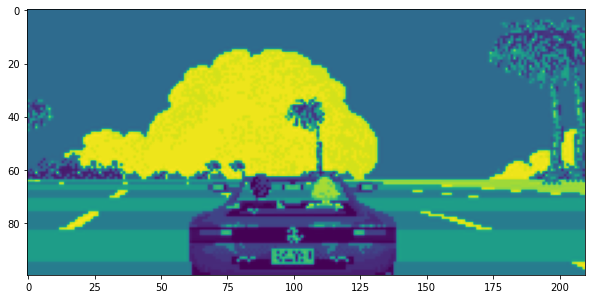

In [18]:
plt.figure(figsize=(10,10))
plt.imshow(queue[2000][0][120:,60:270])

In [19]:
queue[2000][1]

[1, 0, 0, 1, 0]

In [20]:
del queue
gc.collect()

13744

#### Creating DataFrame

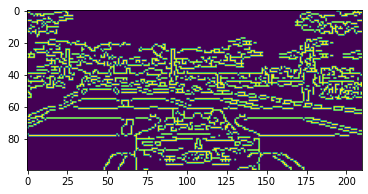

In [21]:
plt.imshow(frame_imgs[350,:,:,0])

Arrumando Comandos


In [25]:
com = [(1000*1 if i[0] == 1 and i[1] == 0 else 0) +  100*i[1]    +10*i[2]  +1*i[3]  for i in actions]

In [26]:
com = pd.get_dummies(com)

In [27]:
com.describe()

,0,1,10,100,101,110,1000,1001,1010
count,27349.000000,27349.000000,27349.000000,27349.000000,27349.000000,27349.000000,27349.000000,27349.000000,27349.000000
mean,0.032360,0.034334,0.026180,0.001609,0.015540,0.016308,0.413726,0.238071,0.221873
std,0.176956,0.182089,0.159674,0.040079,0.123689,0.126658,0.492510,0.425911,0.415514
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [28]:
com.columns

Int64Index([0, 1, 10, 100, 101, 110, 1000, 1001, 1010], dtype='int64')

In [29]:
com.shape, len(frame_imgs)

((27349, 9), 27349)

aqui:

In [33]:
#input_shape = (img_rows, img_cols, 1)
input_shape = (frame_imgs.shape[1], frame_imgs.shape[2], 5)
num_classes = com.shape[1]
batch_size = 256
epochs = 15 #600
input_shape,num_classes

((100, 210, 5), 9)

In [62]:
# CRIANDO MODELO
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Lambda(lambda x: x/255-0.5,input_shape=input_shape))
model.add(tf.keras.layers.Conv2D(32, kernel_size=(20, 20), strides=(1, 1)))
model.add(tf.keras.layers.Activation('elu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(rate=0.5))
model.add(tf.keras.layers.Conv2D(64, kernel_size=(5, 5), strides=(2, 2)))
model.add(tf.keras.layers.Activation('elu'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),bias_regularizer=tf.keras.regularizers.l2(1e-4),activity_regularizer=tf.keras.regularizers.l2(1e-5)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(rate=0.5))
model.add(tf.keras.layers.Dense(128, activation='relu',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),bias_regularizer=tf.keras.regularizers.l2(1e-4),activity_regularizer=tf.keras.regularizers.l2(1e-5)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(rate=0.5))
model.add(tf.keras.layers.Dense(64, activation='relu',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),bias_regularizer=tf.keras.regularizers.l2(1e-4),activity_regularizer=tf.keras.regularizers.l2(1e-5)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(num_classes,activation='linear',name='output'))

In [63]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_10 (Lambda)           (None, 100, 210, 5)       0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 81, 191, 32)       64032     
_________________________________________________________________
activation_10 (Activation)   (None, 81, 191, 32)       0         
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 40, 95, 32)        0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 40, 95, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 18, 46, 64)        51264     
_________________________________________________________________
activation_11 (Activation)   (None, 18, 46, 64)      

In [64]:
# train, test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(range(0,com.shape[0]),range(0,com.shape[0]), test_size=0.05, random_state=42)

In [65]:
#model.compile(loss=keras.losses.binary_crossentropy,
#              optimizer=keras.optimizers.Adam(lr=INIT_LR, decay=INIT_LR / epochs),
#              metrics=['accuracy'])
INIT_LR = 1e-2
model.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=tf.keras.optimizers.SGD(),
              metrics=['mse','mae'])

In [66]:
gc.collect()

166

In [67]:
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,verbose=0, mode='min')
mcp_save = tf.keras.callbacks.ModelCheckpoint('D:\Reinforced_Outrun\Action_Encoded_Model\modelo_outrun_encoded_learning_best_mse.hdf5', save_best_only=True, monitor='val_loss', mode='auto')
#reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=0, min_delta=1e-4, mode='auto')

model.fit(
    frame_imgs[X_train,:,:,:], com.values[X_train],
    batch_size=batch_size,
    epochs=epochs,
    shuffle = True,
    validation_data=(frame_imgs[X_test,:,:,:], com.values[X_test]),
    #callbacks=[mcp_save, earlyStopping]
         )

Train on 25981 samples, validate on 1368 samples
Epoch 1/15
25981/25981 [==============================] - ETA: 15:01 - loss: 2.6151 - mse: 1.7879 - mae: 1.05 - ETA: 8:24 - loss: 2.5999 - mse: 1.7727 - mae: 1.0523 - ETA: 6:11 - loss: 2.5806 - mse: 1.7533 - mae: 1.042 - ETA: 4:52 - loss: 2.5900 - mse: 1.7626 - mae: 1.043 - ETA: 4:04 - loss: 2.5900 - mse: 1.7625 - mae: 1.043 - ETA: 3:32 - loss: 2.5824 - mse: 1.7549 - mae: 1.042 - ETA: 3:09 - loss: 2.5752 - mse: 1.7476 - mae: 1.039 - ETA: 2:51 - loss: 2.5578 - mse: 1.7302 - mae: 1.034 - ETA: 2:37 - loss: 2.5503 - mse: 1.7226 - mae: 1.032 - ETA: 2:26 - loss: 2.5455 - mse: 1.7177 - mae: 1.030 - ETA: 2:17 - loss: 2.5349 - mse: 1.7071 - mae: 1.026 - ETA: 2:09 - loss: 2.5302 - mse: 1.7023 - mae: 1.025 - ETA: 2:02 - loss: 2.5186 - mse: 1.6907 - mae: 1.021 - ETA: 1:56 - loss: 2.5126 - mse: 1.6846 - mae: 1.019 - ETA: 1:51 - loss: 2.4981 - mse: 1.6701 - mae: 1.015 - ETA: 1:46 - loss: 2.4910 - mse: 1.6629 - mae: 1.013 - ETA: 1:42 - loss: 2.4817 - m

In [77]:
model_json = model.to_json()
with open("D:\Reinforced_Outrun\Action_Encoded_Model\modelo_outrun_ae.json", "w") as json_file:
    json_file.write(model_json)

In [78]:
model.save_weights("D:\Reinforced_Outrun\Action_Encoded_Model\modelo_outrun_ae.hdf5")

In [79]:
model.save("D:\Reinforced_Outrun\Action_Encoded_Model\modelo_outrun_ae")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: D:\Reinforced_Outrun\Action_Encoded_Model\modelo_outrun_ae\assets


In [81]:
score_model = model.evaluate(frame_imgs[X_test,:,:,:], com.values[X_test], verbose=0)
print('Test loss:', score[0])

Test loss: 0.5


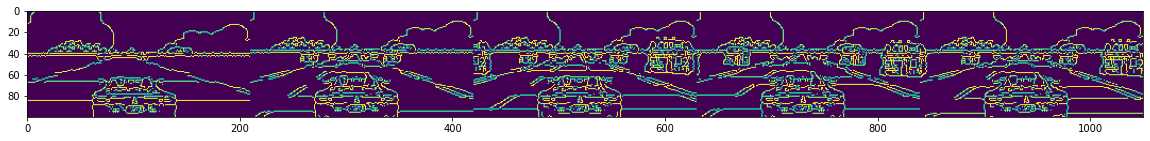

0       0
1       0
10      0
100     0
101     0
110     0
1000    1
1001    0
1010    0
Name: 246, dtype: uint8
[ -5.04   4.83  -6.66 -12.71  -5.18  -5.91  81.23   7.95  13.5 ]
Soma 0.7201391


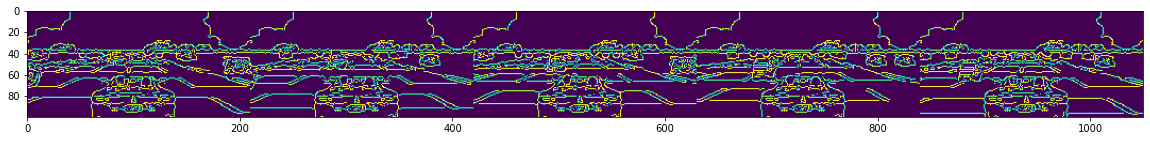

0       0
1       0
10      0
100     0
101     0
110     0
1000    1
1001    0
1010    0
Name: 2112, dtype: uint8
[ 1.89  2.83  3.39 -3.72 -4.55 -9.74 77.59  6.29 34.06]
Soma 1.080316


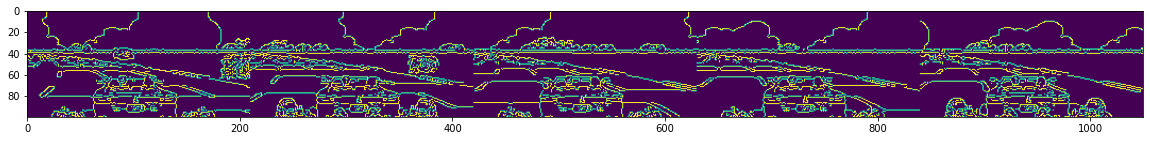

0       0
1       0
10      0
100     0
101     0
110     0
1000    0
1001    1
1010    0
Name: 2510, dtype: uint8
[ 4.71  1.16  7.98  3.48  7.81  1.42  5.28 72.15 13.12]
Soma 1.1710824


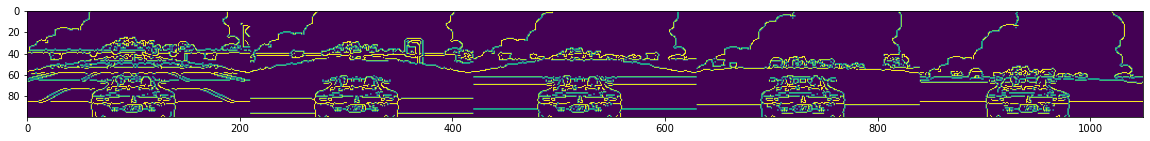

0       0
1       0
10      0
100     0
101     0
110     0
1000    0
1001    1
1010    0
Name: 4501, dtype: uint8
[ 14.7   -8.07  12.47  -0.53  16.05 -11.65  66.    23.42  11.17]
Soma 1.2356203


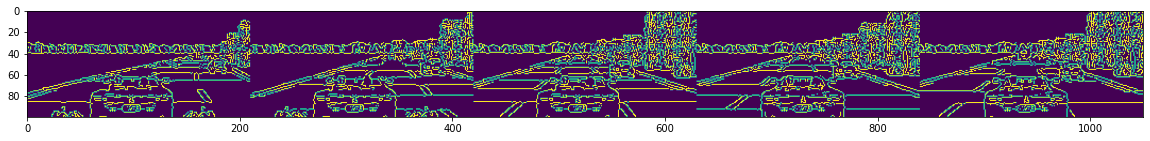

0       0
1       0
10      0
100     0
101     0
110     0
1000    1
1001    0
1010    0
Name: 5084, dtype: uint8
[-1.76  6.64 -3.88 -9.4   1.71 -3.94 73.52  7.3  27.73]
Soma 0.9791994


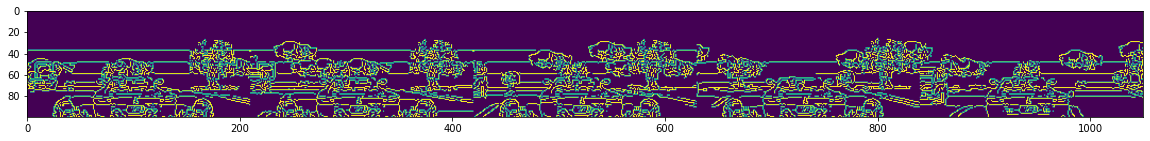

0       0
1       0
10      0
100     0
101     0
110     0
1000    0
1001    1
1010    0
Name: 6440, dtype: uint8
[ 1.038e+01 -3.820e+00  9.540e+00  6.210e+00  5.050e+00  1.000e-02
  3.495e+01  1.174e+01  2.734e+01]
Soma 1.0138714


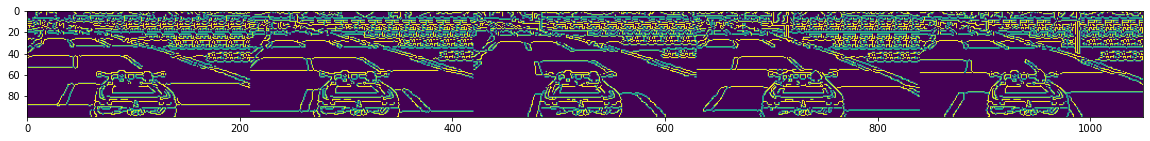

0       0
1       0
10      0
100     0
101     0
110     0
1000    0
1001    1
1010    0
Name: 7108, dtype: uint8
[-25.55  -6.97   1.05  -4.41  12.56  -7.13   6.07  74.37  -3.83]
Soma 0.46172076


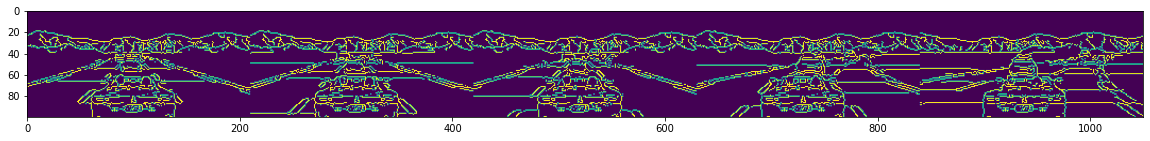

0       0
1       0
10      0
100     0
101     0
110     0
1000    0
1001    0
1010    1
Name: 8306, dtype: uint8
[  3.53  13.05   1.14 -10.44  -2.09  -2.19  54.14   6.39  30.82]
Soma 0.94356656


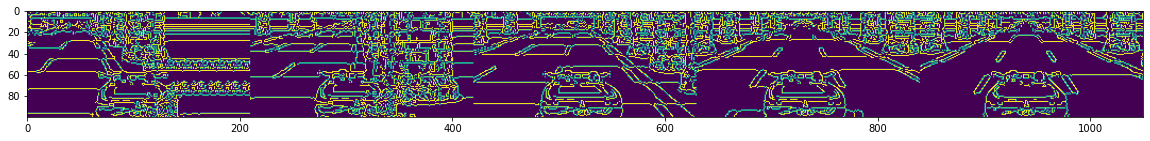

0       0
1       0
10      0
100     0
101     0
110     0
1000    1
1001    0
1010    0
Name: 8489, dtype: uint8
[-15.86  -1.39   3.18  -5.23   2.92 -10.28  56.41  39.83   7.3 ]
Soma 0.76871634


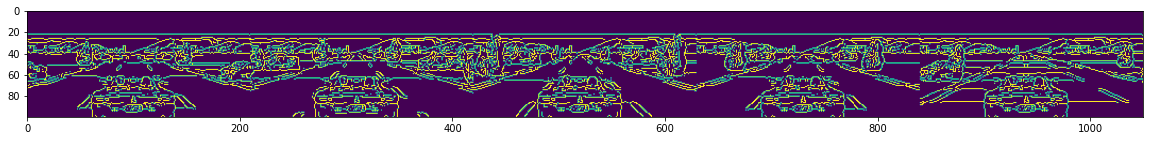

0       0
1       0
10      0
100     0
101     0
110     0
1000    1
1001    0
1010    0
Name: 8980, dtype: uint8
[ 9.51  0.68 -1.22 -6.54 11.25  9.84 91.38 -4.05 25.15]
Soma 1.3599565


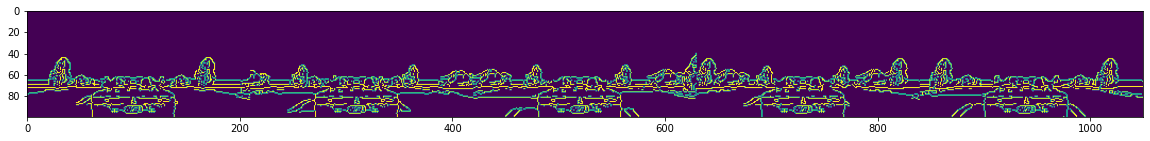

0       0
1       0
10      0
100     0
101     0
110     0
1000    1
1001    0
1010    0
Name: 12066, dtype: uint8
[ -1.04  -0.5  -11.99   3.27  -6.14  14.3   62.04  10.04  25.89]
Soma 0.95870763


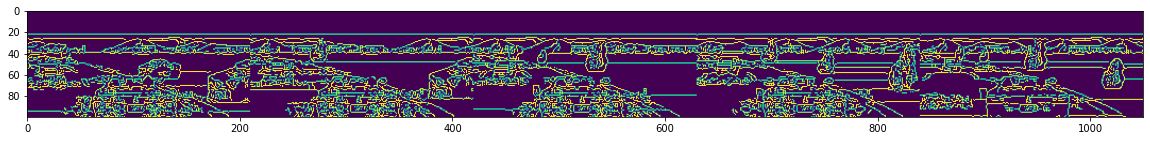

0       0
1       0
10      0
100     0
101     0
110     0
1000    0
1001    1
1010    0
Name: 12221, dtype: uint8
[ 5.82  5.59  6.57 -6.72  5.43  3.91 31.38 33.4   2.82]
Soma 0.88202083


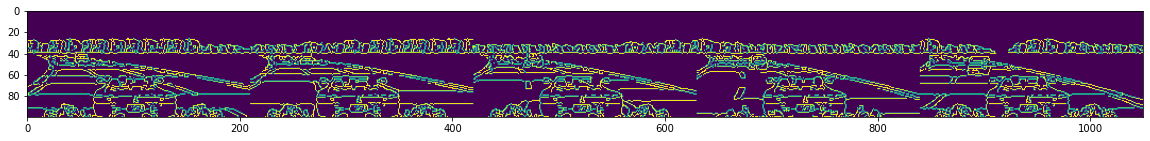

0       0
1       0
10      0
100     0
101     0
110     0
1000    0
1001    1
1010    0
Name: 14653, dtype: uint8
[  6.95   6.61   4.6   10.31   4.4  -10.2    5.07  78.06   6.17]
Soma 1.1198435


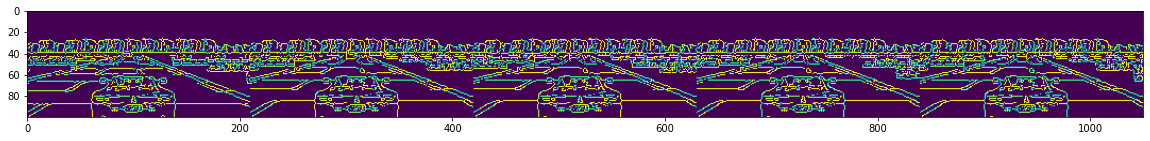

0       0
1       0
10      0
100     0
101     0
110     0
1000    1
1001    0
1010    0
Name: 14710, dtype: uint8
[-6.42  2.72 -2.61 -3.93  2.2  -1.76 56.54  9.17 38.3 ]
Soma 0.9420586


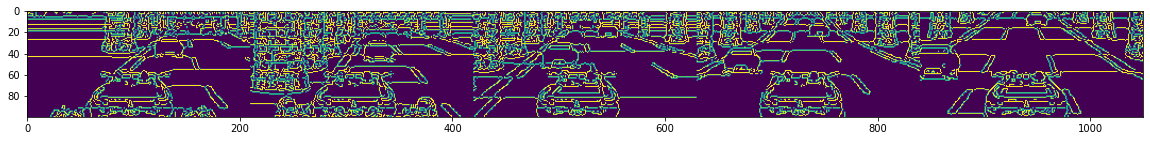

0       0
1       0
10      0
100     0
101     0
110     0
1000    1
1001    0
1010    0
Name: 15036, dtype: uint8
[-1.33 -3.79  1.64 -6.05 -2.82 -1.16 65.05  6.33 32.99]
Soma 0.9086053


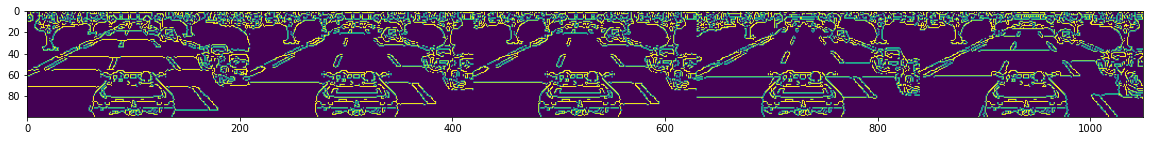

0       0
1       0
10      0
100     0
101     0
110     0
1000    1
1001    0
1010    0
Name: 16151, dtype: uint8
[ -7.32  -6.93  -3.74  -7.19   3.32  -6.39 102.94  12.09   2.74]
Soma 0.89510554


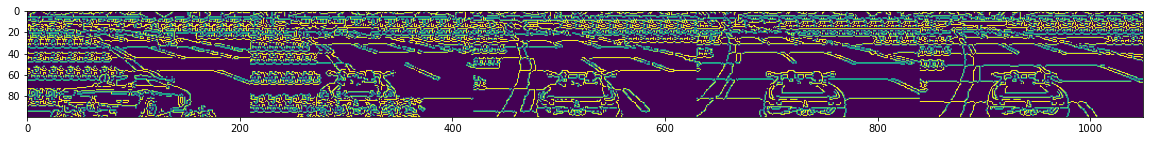

0       0
1       0
10      0
100     0
101     0
110     0
1000    0
1001    1
1010    0
Name: 16834, dtype: uint8
[-19.88  -6.91   7.39  -6.45  11.21  -5.5   33.92  43.71   9.24]
Soma 0.6674601


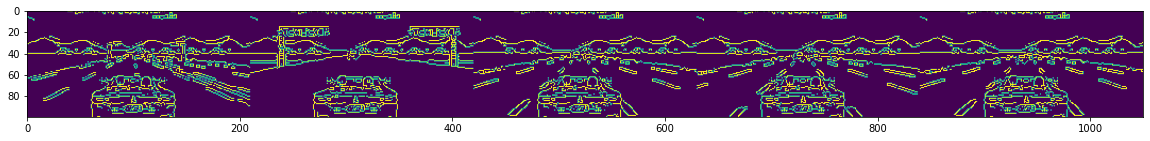

0       0
1       0
10      0
100     0
101     0
110     0
1000    0
1001    0
1010    1
Name: 17069, dtype: uint8
[  2.62  12.27 -11.48  -8.7    3.68  -3.35  85.52   6.85   1.86]
Soma 0.89261925


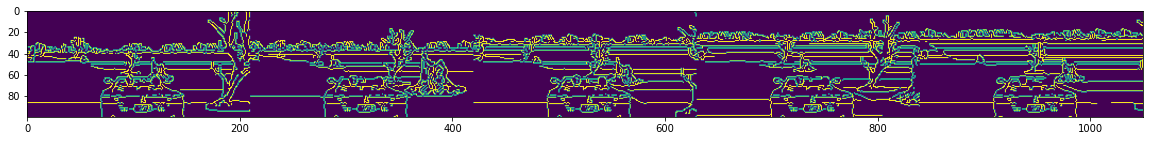

0       0
1       0
10      0
100     0
101     0
110     0
1000    0
1001    1
1010    0
Name: 22287, dtype: uint8
[11.8  10.18  9.75 -4.74 -3.11 -1.01 44.28 45.14  7.61]
Soma 1.1990954


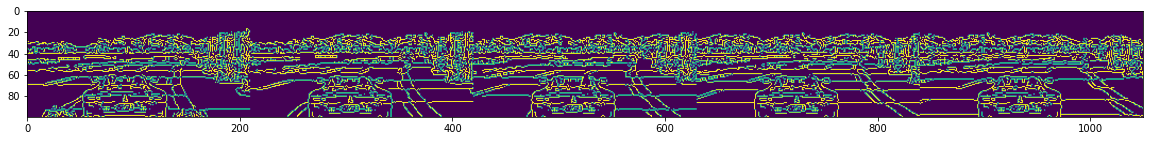

0       0
1       0
10      0
100     0
101     0
110     0
1000    1
1001    0
1010    0
Name: 23617, dtype: uint8
[-3.9   4.04  8.03 -7.07  6.12  1.93 36.59 10.52 39.08]
Soma 0.95336825


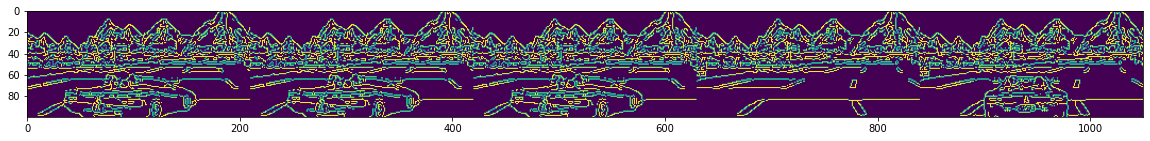

0       0
1       0
10      0
100     0
101     0
110     0
1000    1
1001    0
1010    0
Name: 24744, dtype: uint8
[10.29  1.27 14.86  0.89  2.21 -3.14 40.14 22.26 41.48]
Soma 1.3025748


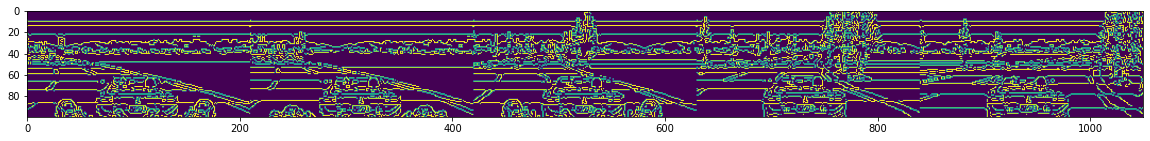

0       0
1       0
10      0
100     0
101     0
110     0
1000    0
1001    0
1010    1
Name: 25088, dtype: uint8
[ 8.32  3.79 13.79 -6.58  3.29 -8.84 45.12 27.44 24.37]
Soma 1.107077


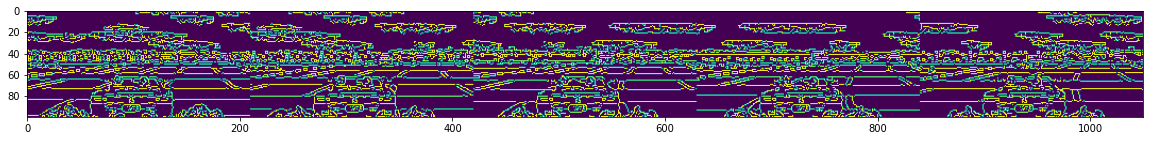

0       0
1       0
10      0
100     0
101     0
110     0
1000    0
1001    0
1010    1
Name: 25367, dtype: uint8
[-5.89  3.98 12.08 -7.67 -5.47  1.51 31.02 -7.28 62.38]
Soma 0.8467021


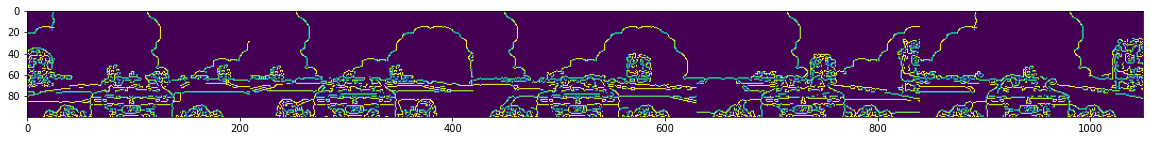

0       0
1       0
10      0
100     0
101     0
110     0
1000    0
1001    1
1010    0
Name: 25834, dtype: uint8
[ 1.66 -2.78 -6.33  4.22  4.06  0.56 53.29 16.55 25.54]
Soma 0.96773887


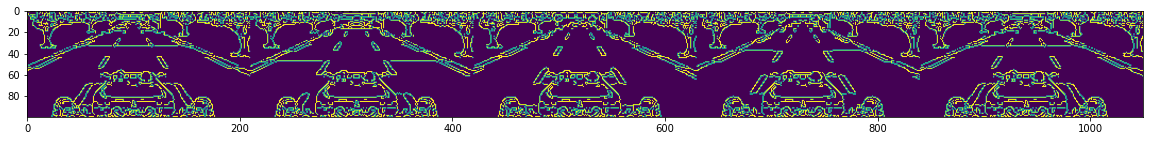

0       0
1       0
10      0
100     0
101     0
110     0
1000    1
1001    0
1010    0
Name: 26124, dtype: uint8
[-6.86 -5.58  5.71 -7.14  3.39 -9.49 94.27 -5.07 20.73]
Soma 0.89970016


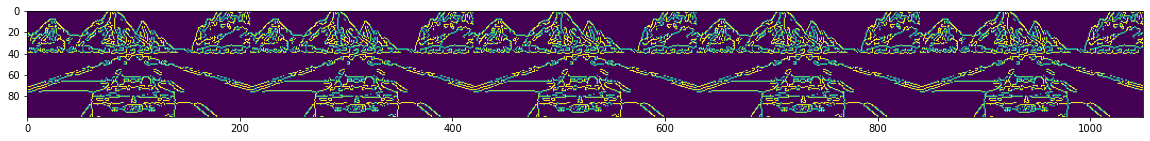

0       0
1       0
10      0
100     0
101     0
110     0
1000    1
1001    0
1010    0
Name: 26305, dtype: uint8
[-5.54 11.55  6.51 -5.88  5.97 -3.27 77.47 -6.34 15.17]
Soma 0.9563407


In [76]:
for i in range(0,frame_imgs.shape[0]):
    if np.random.rand() < 0.001:
        plt.figure(figsize=(20,20))
        plt.imshow(np.hstack(np.array([frame_imgs[i,:,:,0],frame_imgs[i,:,:,1],frame_imgs[i,:,:,2],frame_imgs[i,:,:,3],frame_imgs[i,:,:,4]])))
        plt.show()
        print(com.iloc[i])
        print(np.round(model.predict(np.expand_dims(frame_imgs[i,:,:,:],axis=0))[0]*100,2))
        print('Soma',np.sum(model.predict(np.expand_dims(frame_imgs[i,:,:,:],axis=0))))